In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from scipy.stats import pearsonr
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
import torch
from scipy.stats import ttest_ind

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
%pip install gensim

In [ ]:
# # Load the entire labelled dataset
# df = pd.read_csv(path_data + "entire_dataset_labeled_final.csv")
# # Filter the rows with labels == 1
# df = df[df['labels'] == 1]

In [ ]:
path_folder = ""
df = pd.read_csv(path_folder+"data/df_with_bot_scores.csv")

In [ ]:
len(df)

338641

In [ ]:
len(df.author_id.unique())

27016

In [ ]:
# Extract week information from the 'created_at' column
df['created_at'] = pd.to_datetime(df['created_at'])
df['week'] = df['created_at'].dt.strftime('%Y-%U')

In [ ]:
pip install botometer

In [ ]:
import botometer

rapidapi_key = ""

bomx = botometer.BotometerX(rapidapi_key=rapidapi_key)

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
# list_id_1 = list(df["author_id"].iloc[0:100])

In [ ]:
# len(set(list_id_1))

In [ ]:
# list_id_1_response = bomx.get_botscores_in_batch(user_ids=list_id_1)

In [ ]:
# ---- Step 0. Prepare unique user list ----
unique_users = df["author_id"].drop_duplicates().reset_index(drop=True)

In [ ]:
len(unique_users)

27016

In [ ]:
# # ---- Step 1. Handle first batch (already done) ----
# results_batch1 = pd.DataFrame(list_id_1_response)[["user_id", "bot_score"]]
# results_batch1["user_id"] = results_batch1["user_id"].astype(np.int64)
# results_batch1 = results_batch1.rename(columns={"user_id": "author_id"})

In [ ]:
# # Dictionary of bot scores
# bot_scores_dict = dict(zip(results_batch1["author_id"], results_batch1["bot_score"]))

In [ ]:
# # Number of unique users already processed
# n_done = len(results_batch1)

In [ ]:
# # Set of the first 65 user IDs already queried
# already_done_ids = set(results_batch1["author_id"])

# # Example: check first continuation slice
# users_to_check = unique_users.iloc[n_done:n_done+100]  # n_done = 65

# # Verify overlap
# overlap = set(users_to_check).intersection(already_done_ids)

# print("Overlap with first 65 users:", overlap)

Overlap with first 65 users: set()


In [ ]:
# ---- Step 2. Continue batching from user index 65 ----
def continue_bot_scores(unique_users, start_index, batch_size=100, max_batches=50):
    all_results = []

    users_to_check = unique_users.iloc[start_index:start_index + batch_size * max_batches]

    for i in range(0, len(users_to_check), batch_size):
        batch = list(users_to_check.iloc[i:i+batch_size])
        try:
            response = bomx.get_botscores_in_batch(user_ids=batch)
            all_results.extend(response)
        except Exception as e:
            print(f"Batch {i//batch_size+1} failed: {e}")

    if all_results:
        results_df = pd.DataFrame(all_results)[["user_id", "bot_score"]]
        results_df["user_id"] = results_df["user_id"].astype(np.int64)
        results_df = results_df.rename(columns={"user_id": "author_id"})
        return results_df
    else:
        return pd.DataFrame(columns=["author_id", "bot_score"])

In [ ]:
# # Run continuation (start at 65, since those are done)
# results_rest = continue_bot_scores(unique_users, start_index=n_done)

# # Add to dictionary
# bot_scores_dict.update(dict(zip(results_rest["author_id"], results_rest["bot_score"])))

In [ ]:
# # ---- Step 3. Map back to full df ----
# df["bot_score"] = df["author_id"].map(bot_scores_dict)

In [ ]:
# # Save dictionary of all processed bot scores
# import pickle

# with open(path_folder+"results/bot_scores_progress.pkl", "wb") as f:
#     pickle.dump(bot_scores_dict, f)

# # Also save the index of where we stopped
# progress = {"last_index": n_done + len(results_rest)}
# with open(path_folder+"results/progress_index.pkl", "wb") as f:
#     pickle.dump(progress, f)

# print(f"✅ Saved progress up to user index {progress['last_index']}")

✅ Saved progress up to user index 4944


In [ ]:
# df.to_csv(path_folder+"data/df_with_bot_scores.csv", index=False)

Unique users with bot_score: 21872
Average bot_score: 0.20577335558065107
Median bot_score: 0.16
Min bot_score: 0.0
Max bot_score: 1.0
Percentage of users with bot_score > 0.5: 6.07%


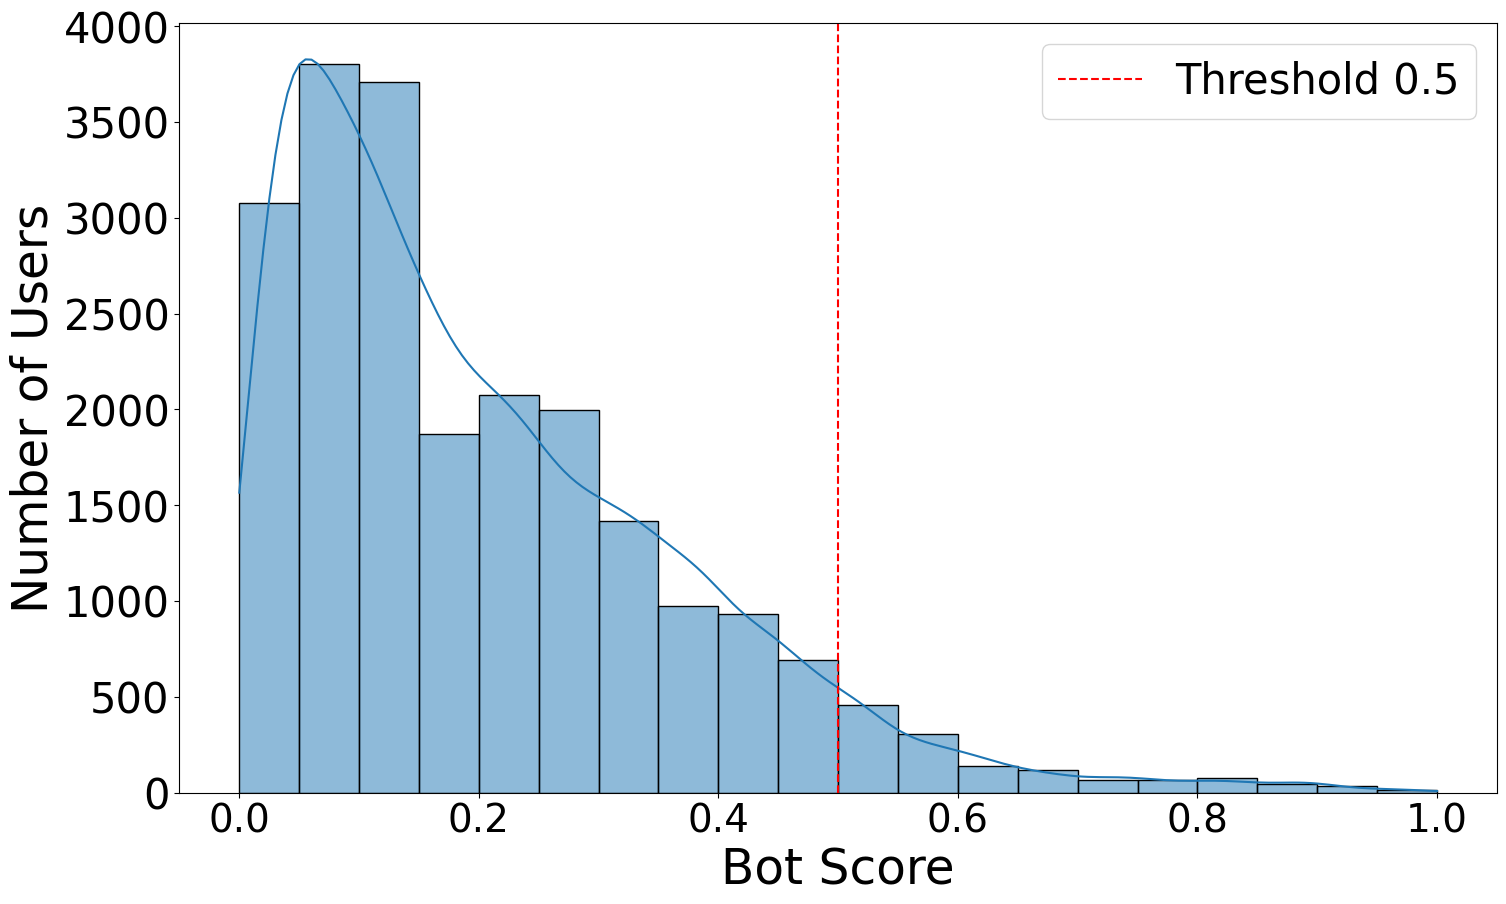

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Consider only unique users ---
unique_scores = df.drop_duplicates(subset="author_id")["bot_score"].dropna()

# --- Stats ---
print("Unique users with bot_score:", len(unique_scores))
print("Average bot_score:", unique_scores.mean())
print("Median bot_score:", unique_scores.median())
print("Min bot_score:", unique_scores.min())
print("Max bot_score:", unique_scores.max())

# --- Percentage above 0.5 ---
pct_above_05 = (unique_scores >= 0.5).mean() * 100
print(f"Percentage of users with bot_score > 0.5: {pct_above_05:.2f}%")

# --- Distribution plot ---
plt.figure(figsize=(17,10))
sns.histplot(unique_scores, bins=20, kde=True)
plt.axvline(0.5, color="red", linestyle="--", label="Threshold 0.5")
plt.xlabel("Bot Score", fontsize=35)
plt.ylabel("Number of Users", fontsize=35)
#plt.title("Distribution of Botometer Scores (Unique Users)")
plt.xticks(fontsize=28)
plt.yticks(fontsize=30)
plt.legend(fontsize=30)
plt.savefig(path_folder+"figures/botometer_score_distrib.png")
plt.show()

In [ ]:
# --- Unique users and their scores ---
unique_scores = df.drop_duplicates(subset="author_id")[["author_id", "bot_score"]].dropna()

# --- Select only users above threshold ---
bots = unique_scores[unique_scores["bot_score"] > 0.5]["author_id"]

# --- Count how many tweets in df belong to these users ---
n_tweets_from_bots = df[df["author_id"].isin(bots)].shape[0]
n_total_tweets = df.shape[0]
pct_tweets_from_bots = (n_tweets_from_bots / n_total_tweets) * 100

print(f"Tweets from users with bot_score > 0.5: {n_tweets_from_bots}")
print(f"Total tweets: {n_total_tweets}")
print(f"Percentage of tweets from likely bots: {pct_tweets_from_bots:.2f}%")

Tweets from users with bot_score > 0.5: 7958
Total tweets: 338641
Percentage of tweets from likely bots: 2.35%


In [ ]:
import pickle

# Load previous progress
with open(path_folder+"results/bot_scores_progress.pkl", "rb") as f:
    bot_scores_dict = pickle.load(f)

with open(path_folder+"results/progress_index.pkl", "rb") as f:
    progress = pickle.load(f)

# Find where to restart
start_index = progress["last_index"]
print(f"Resuming from user index {start_index}")

Resuming from user index 27016


In [ ]:
# unique_users = df["author_id"].drop_duplicates().reset_index(drop=True)

In [ ]:
# Continue batches for another 50 requests (up to 5000 users total)
results_new = continue_bot_scores(unique_users, start_index=start_index)

# Update dictionary
bot_scores_dict.update(dict(zip(results_new["author_id"], results_new["bot_score"])))

# Save again after today’s run
with open(path_folder+"results/bot_scores_progress.pkl", "wb") as f:
    pickle.dump(bot_scores_dict, f)

progress = {"last_index": start_index + len(results_new)}
with open(path_folder+"results/progress_index.pkl", "wb") as f:
    pickle.dump(progress, f)

print(f"✅ Saved progress up to user index {progress['last_index']}")

# Finally, map back to full df
df["bot_score"] = df["author_id"].map(bot_scores_dict)


✅ Saved progress up to user index 27016


In [ ]:
#df.to_csv(path_folder+"data/df_with_bot_scores.csv", index=False)

## Check the impact of bots on the results

In [ ]:
#df = pd.read_csv(path_folder+"data/df_with_bot_scores.csv")

In [ ]:
len(df)

338641

In [ ]:
print(f"Original tweets: {len(df)}")

# Remove rows where bot_score > 0.5
df = df[(df["bot_score"].isna()) | (df["bot_score"] <= 0.5)].copy()

print(f"Remaining tweets after removing likely bots: {len(df)}")
print(f"Removed {338641 - len(df)} tweets from accounts with bot_score > 0.5")

Original tweets: 338641
Remaining tweets after removing likely bots: 330683
Removed 7958 tweets from accounts with bot_score > 0.5


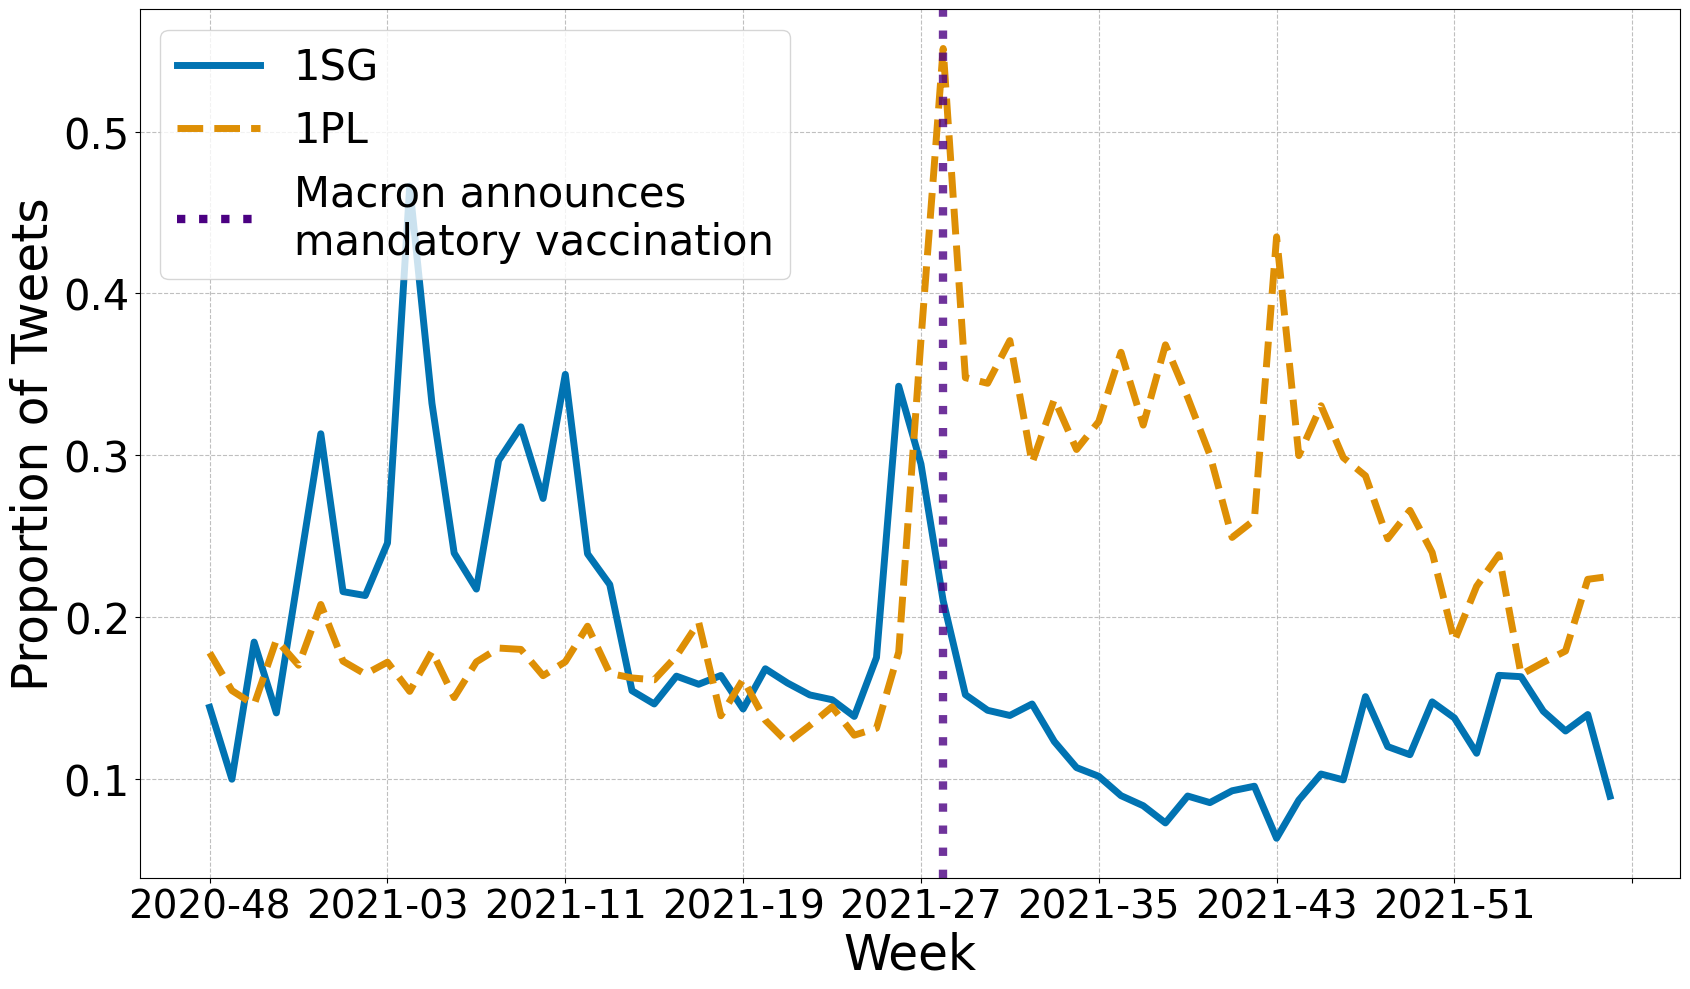

In [ ]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# Define the list of pronouns to track
pronouns = [
    ["je", "j'", "me", "moi", "mien", "mienne", "miens", "miennes", "ma", "mon"],
    ["nous", "notre", "notres", "nôtre", "nôtres", "nos"]
]

# Initialize labels for each group of pronouns
all_labels = []

# Iterate through each group of pronouns
for group in pronouns:
    labels = []
    for tweet in df["tweet_clean0"].str.lower():
        has_pronoun = any(pronoun in tweet.replace("-", " ").split() for pronoun in group)
        has_hashtag = any(word.startswith(group[0]) for word in tweet.split("#")[1:])
        label = 1 if has_pronoun or has_hashtag else 0
        labels.append(label)
    all_labels.append(labels)

# Create a DataFrame with the labels for each pronoun group
for i, group in enumerate(pronouns):
    df[f"Label_{i+1}"] = all_labels[i]

# Set a new color palette using seaborn
color_palette = sns.color_palette("colorblind")

# Define custom colors
highlight_line_color = '#4B0082'
highlight_fill_color = 'lightcoral'
line_color_1sg = color_palette[0]
line_color_1pl = color_palette[1]

# Define different line styles for the two pronoun groups
linestyle_1sg = '-'
linestyle_1pl = '--'

# Filter to keep only the relevant annotation for the event
relevant_week = '2021-28'  # Exact week for Macron's speech

# Ensure the 'week' column is sorted in the DataFrame and it's a string for comparison
df['week'] = df['week'].astype(str)

# Create the plot
fig, ax = plt.subplots(figsize=(17, 10))

legend_labels = ["1SG", "1PL"]

# Loop through each group of pronouns to calculate proportions and plot
for i in range(len(pronouns)):
    weekly_labels = df.groupby('week')[f"Label_{i+1}"].sum()
    total_tweets_per_week = df['week'].value_counts().sort_index()
    proportion_label_1 = weekly_labels / total_tweets_per_week

    if i == 0:
        ax.plot(proportion_label_1.index, proportion_label_1.values, linestyle=linestyle_1sg, color=line_color_1sg, label=legend_labels[i], linewidth=5, zorder=2)
        # Add the dotted red line for Macron's speech below the other lines
        x_pos = proportion_label_1.index.get_loc(relevant_week)
        #ax.axvline(x=x_pos, color=highlight_line_color, linestyle='dotted', linewidth=2, label='Macron announces mandatory vaccination', zorder=1)

        # Extend the shaded area to the end of the x-axis (use the full range of the index)
        #ax.axvspan(x_pos, len(proportion_label_1.index), facecolor="grey", alpha=0.1, zorder=0)
    else:
        ax.plot(proportion_label_1.index, proportion_label_1.values, linestyle=linestyle_1pl, color=line_color_1pl, label=legend_labels[i], linewidth=5, zorder=2)

# Remove white space on the right side
#ax.set_xlim([-1, len(df['week'].unique())])
# Adjust the y-limit to give space above the lines for the legend
#y_max = proportion_label_1.max()  # Find the maximum y value across categories
#ax.set_ylim(0, y_max * 1.45)  # Increase y limit by 20% to make space for the legend

# Vertical line for Macron speech
ax.axvline(x=x_pos, color=highlight_line_color, linestyle='dotted', linewidth=6, alpha=0.8)

# Customize the x-axis labels
ax.set_xlabel('Week', fontsize=35)
ax.set_ylabel('Proportion of Tweets', fontsize=35)

# Customize the grid and ticks
# Add grid
ax.grid(True, linestyle='--', alpha=0.8)
plt.xticks(fontsize=28)
plt.yticks(fontsize=30)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

# Create a custom legend
handles = [
    mlines.Line2D([0], [0], color=line_color_1sg, linestyle=linestyle_1sg, label='1SG', linewidth=5),
    mlines.Line2D([0], [0], color=line_color_1pl, linestyle=linestyle_1pl, label='1PL', linewidth=5),
    mlines.Line2D([], [], color=highlight_line_color, linestyle='dotted', linewidth=6,
                  label='Macron announces\nmandatory vaccination')
    #mlines.Line2D([0], [1], color=highlight_line_color, linestyle='dotted', linewidth=3, label='Macron announces mandatory vaccination'),
    #mpatches.Patch(facecolor='grey', alpha=0.25, label='Post-announcement period')
]
ax.legend(handles=handles, fontsize=30, loc='upper left')

plt.tight_layout()
plt.savefig(path_folder+"figures/proportion_pronounsgroups_use_nobot.png", dpi=200)
plt.show()

In [ ]:
outgroup_labels = ['gouvernement', 'moutons', 'flics', 'covidistes', 'élites', 'vaccinés', 'médias', 'fdo',
                   'lobotomisés', 'dirigeants', 'préfets', 'boomers', 'macronistes', 'esclaves', 'politiciens',
                   'gouvernants', 'tyrans', 'dictateurs', 'terroristes sanitaires', 'politicards', 'vendus',
                   'larbins', 'lâches', 'enfermistes', 'tarés', 'escrocs', 'collabos', 'charlatans', 'crapules',
                   'mougeons', 'décérébrés', 'nantis', 'fachos', 'dociles', 'journalistes', 'naïfs', 'clowns',
                   'hypocondriaques', 'merdias', 'président', 'ministres', 'alarmistes', 'bobos', 'monstres',
                   'pourritures', 'manipulateurs', 'parasites', 'salauds', 'socialistes', 'macronards', 'spikés',
                   'dosés', 'vaxxinés', 'labos', 'journaleux', 'menteurs', 'khmers', 'hypnotisés', 'pleutres',
                   'toutous', 'veaux', 'obéissants', 'ayatollahs', 'godillots', 'sbires', 'fascistes', 'toubibs',
                   'laboratoires', 'guignols', 'voyous', 'talibans', 'endoctrinés', 'journalopes', 'lobbies',
                   'hystériques', 'assassins', 'minables', 'sorciers', 'apeurés', 'traitres', 'enfoirés',
                   'kapos', 'zélés', 'dingues', 'endormis', 'cocus', 'dégénérés', 'racailles', 'migrants',
                   'incompétents', 'nuls', 'acolytes', 'employeurs', 'complices']

In [ ]:
len(outgroup_labels)

94

In [ ]:
from nltk.tokenize import word_tokenize

def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Keep alphabetic characters and accented letters
    text = re.sub(r'[^a-zA-ZÀ-ÿ#]', ' ', text)  # Remove non-alphabetic characters, keeping @ and #

    # Keep alphabetic characters and accented letters, replace consecutive spaces with a single space
    text = re.sub(r'\s+', ' ', text)

    # Convert to lowercase
    text = text.lower()

    # Replace "non vaccinated" or "non-vaccinated" with "non_vaccinated"
    text = re.sub(r'\bnon(?:[-\s]+)vaccinés\b', 'non_vaccinés', text)
    text = re.sub(r'\bnon(?:[-\s]+)vacciné\b', 'non_vacciné', text)

    # Replace "non vaccinated" or "non-vaccinated" with "non_vaccinated"
    text = re.sub(r'\bnon(?:[-\s]+)injectés\b', 'non_injectés', text)
    text = re.sub(r'\bnon(?:[-\s]+)injecté\b', 'non_injecté', text)

#Added afterwards
    text = re.sub(r'\bnon(?:[-\s]+)vax\b', 'non_vax', text)

    text = re.sub(r'\bnon(?:[-\s]+)vaxx\b', 'non_vaxx', text)

    text = re.sub(r'\bnon(?:[-\s]+)piqués\b', 'non_piqués', text)
    text = re.sub(r'\bnon(?:[-\s]+)piqué\b', 'non_piqué', text)

    text = re.sub(r'\bnon(?:[-\s]+)spikés\b', 'non_spikés', text)
    text = re.sub(r'\bnon(?:[-\s]+)spiké\b', 'non_spiké', text)

    text = re.sub(r'\bnon(?:[-\s]+)dosés\b', 'non_dosés', text)
    text = re.sub(r'\bnon(?:[-\s]+)dosé\b', 'non_dosé', text)

    text = re.sub(r'\bnon(?:[-\s]+)vaxxinés\b', 'non_vaxxinés', text)
    text = re.sub(r'\bnon(?:[-\s]+)vaxxiné\b', 'non_vaxxiné', text)

    text = re.sub(r'\bnon(?:[-\s]+)vacc\b', 'non_vacc', text)

    text = re.sub(r'\bnon(?:[-\s]+)vacx\b', 'non_vacx', text)

    text = re.sub(r'\bnon(?:[-\s]+)vaxxés\b', 'non_vaxxés', text)

    return text.strip()

# Apply the preprocess_text function to the 'tweet' column and store the result in a new column 'preprocessed_text'
df['preprocessed_text'] = df['tweet_clean0'].apply(preprocess_text)

In [ ]:
tokenized_text = df['preprocessed_text'].apply(word_tokenize)
df["tokenized_text"] = tokenized_text

In [ ]:
df_before_july = df[df['created_at'] < '2021-07-12']
df_after_july = df[df['created_at'] >= '2021-07-12']

In [ ]:
import re
from collections import Counter

# Function to compute normalized frequencies for a list of words
def normalized_word_freq(df, words):
    counter = Counter()
    for text in df['preprocessed_text']:
        tokens = re.findall(r'\b\w+\b', str(text).lower())
        counter.update([t for t in tokens if t in words])
    total_tweets = len(df)
    normalized = {word: counter[word]/total_tweets for word in words}
    return normalized

# Compute normalized frequencies before and after July 12
freq_before_selected = normalized_word_freq(df_before_july, outgroup_labels)
freq_after_selected = normalized_word_freq(df_after_july, outgroup_labels)

# Create a DataFrame
df_selected_freq = pd.DataFrame({
    'before': pd.Series(freq_before_selected),
    'after': pd.Series(freq_after_selected)
}).fillna(0)

# Compute change
df_selected_freq['diff'] = df_selected_freq['after'] - df_selected_freq['before']
df_selected_freq['pct_change'] = df_selected_freq['diff'] / (df_selected_freq['before'] + 1e-6) * 100

/tmp/ipython-input-1112212669.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='diff', y=df_plot.index, data=df_plot, palette='coolwarm')


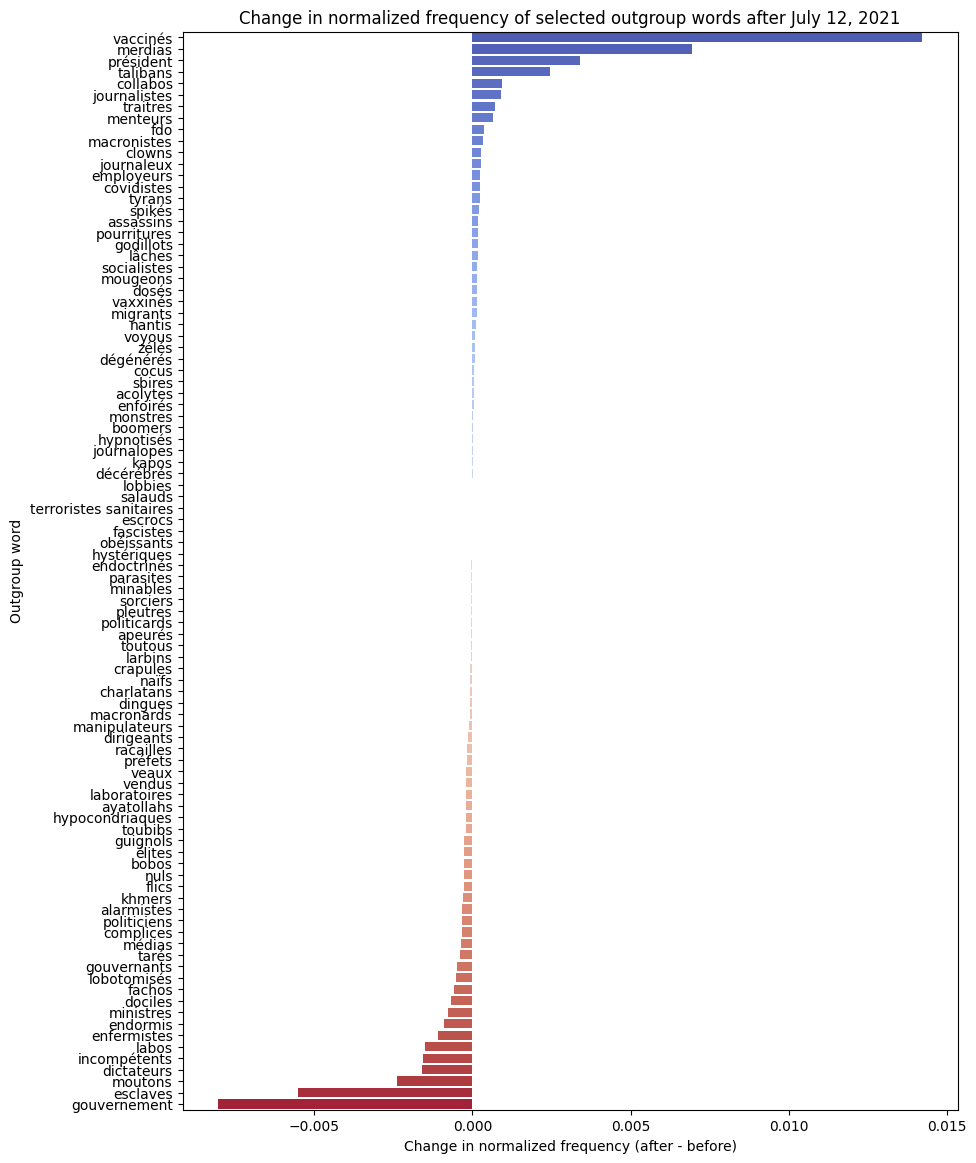

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by largest increase
df_plot = df_selected_freq.sort_values('diff', ascending=False)

plt.figure(figsize=(10,14))
sns.barplot(x='diff', y=df_plot.index, data=df_plot, palette='coolwarm')
plt.title("Change in normalized frequency of selected outgroup words after July 12, 2021")
plt.xlabel("Change in normalized frequency (after - before)")
plt.ylabel("Outgroup word")
plt.show()

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

significant_words = []

for word in df_selected_freq.index:
    # Counts before and after
    count_before = int(freq_before_selected.get(word, 0) * len(df_before_july))
    nobs_before = len(df_before_july)
    count_after = int(freq_after_selected.get(word, 0) * len(df_after_july))
    nobs_after = len(df_after_july)

    # z-test for proportions
    counts = [count_before, count_after]
    nobs = [nobs_before, nobs_after]
    stat, pval = proportions_ztest(counts, nobs)

    if pval < 0.05:  # significant at 5%
        significant_words.append(word)

print(f"{len(significant_words)} words changed significantly")

49 words changed significantly


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std


/tmp/ipython-input-1056182135.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


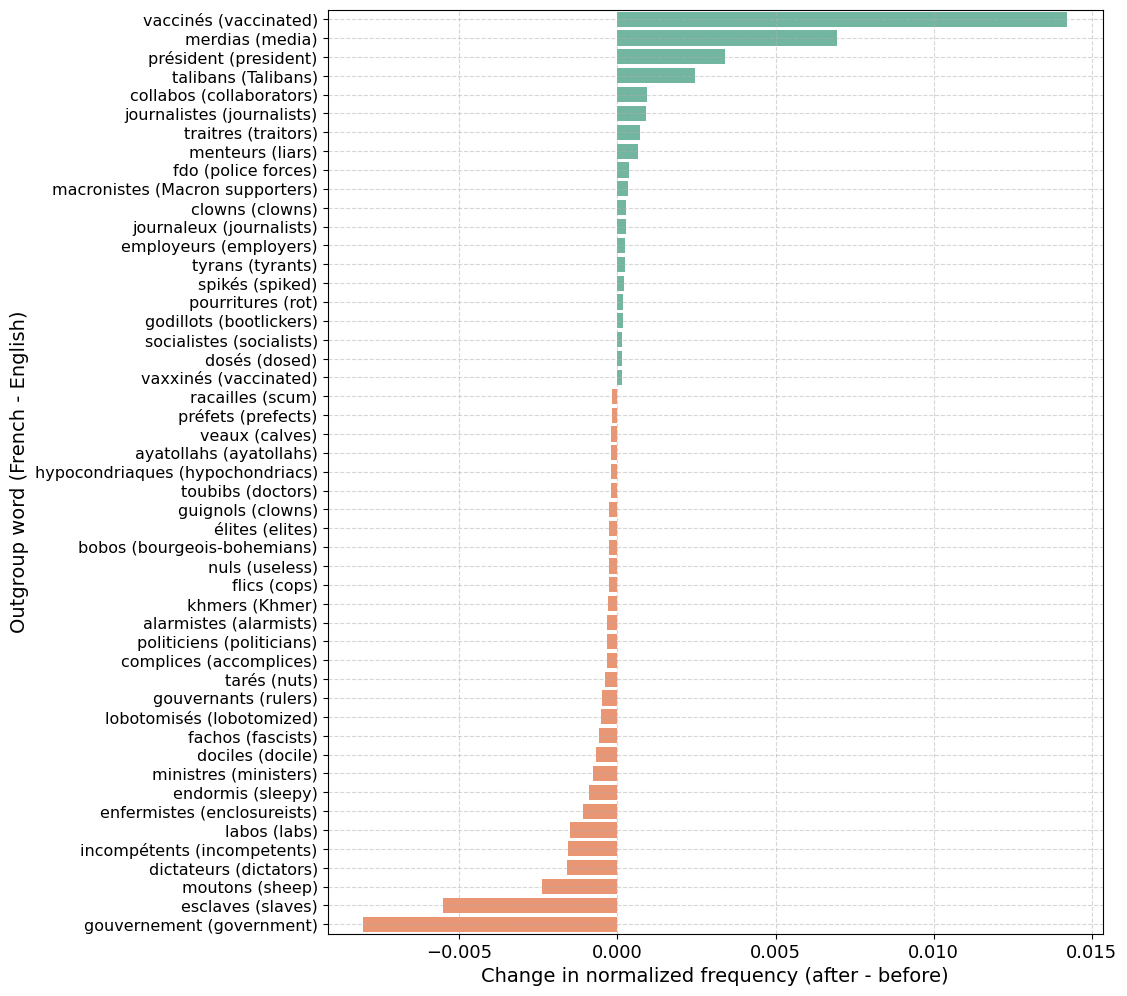

In [ ]:
import seaborn as sns

# Example translation dictionary (you can expand this)
translations = {
    'gouvernement': 'government', 'moutons': 'sheep', 'flics': 'cops', 'covidistes': 'covidists',
    'élites': 'elites', 'vaccinés': 'vaccinated', 'fdo': 'police forces', 'lobotomisés': 'lobotomized',
    'préfets': 'prefects', 'macronistes': 'Macron supporters', 'esclaves': 'slaves', 'politiciens': 'politicians',
    'gouvernants': 'rulers', 'tyrans': 'tyrants', 'dictateurs': 'dictators', 'vendus': 'sellouts',
    'enfermistes': 'enclosureists', 'tarés': 'nuts', 'collabos': 'collaborators', 'fachos': 'fascists',
    'dociles': 'docile', 'journalistes': 'journalists', 'clowns': 'clowns', 'hypocondriaques': 'hypochondriacs',
    'merdias': 'media', 'président': 'president', 'ministres': 'ministers', 'alarmistes': 'alarmists',
    'bobos': 'bourgeois-bohemians', 'pourritures': 'rot', 'socialistes': 'socialists', 'spikés': 'spiked',
    'dosés': 'dosed', 'vaxxinés': 'vaccinated', 'labos': 'labs', 'journaleux': 'journalists',
    'menteurs': 'liars', 'khmers': 'Khmer', 'toutous': 'puppets', 'veaux': 'calves', 'ayatollahs': 'ayatollahs',
    'godillots': 'bootlickers', 'toubibs': 'doctors', 'guignols': 'clowns', 'talibans': 'Talibans',
    'traitres': 'traitors', 'endormis': 'sleepy', 'racailles': 'scum', 'migrants': 'migrants',
    'incompétents': 'incompetents', 'nuls': 'useless', 'employeurs': 'employers', 'complices': 'accomplices'
}

# Filter the DataFrame
df_significant = df_selected_freq.loc[significant_words].sort_values('diff', ascending=False)

# Set Seaborn palette
sns.set_palette("Set2")
regular_color_new_users = sns.color_palette("Set2")[0]  # e.g., greenish
regular_color_persistent_users = sns.color_palette("Set2")[1]  # e.g., purplish

# Add translation column
df_significant['translation'] = df_significant.index.map(translations)

# Assign color based on sign of 'diff'
def color_map_fixed(val):
    return regular_color_new_users if val >= 0 else regular_color_persistent_users

colors = df_significant['diff'].apply(color_map_fixed).tolist()

# Create plot
plt.figure(figsize=(10,12))
sns.barplot(
    x='diff',
    y=df_significant.index + " (" + df_significant['translation'] + ")",
    data=df_significant,
    palette=colors
)
#plt.title("Change in normalized frequency of significantly changing outgroup words after July 12, 2021")
plt.xlabel("Change in normalized frequency (after - before)", fontsize=14)
plt.ylabel("Outgroup word (French - English)", fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=11.5)
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(path_folder+"figures/outgrouplabels_frequency_nobot.png", dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['week'] = df['created_at'].dt.strftime('%Y-%U')

# Calculate the top 10% authors who publish the most
top_10_percent_authors = df['author_id'].value_counts().nlargest(int(len(df['author_id'].unique()) * 0.1)).index

# Filter the DataFrame based on the top 10% authors
df_top_10_percent = df[df['author_id'].isin(top_10_percent_authors)]

# Function to filter authors based on the new condition
def filter_activists(df):
    # Get the number of unique months each author has posted in
    author_post_months = df.groupby('author_id')['created_at'].apply(lambda x: x.dt.month.nunique())

    # Filter authors who have posted in every month
    prolific_authors = author_post_months[author_post_months >= 10].index

    # Filter the DataFrame based on prolific authors
    df_activists = df[df['author_id'].isin(prolific_authors)]

    return df_activists

# Apply the prolific condition to the original DataFrame
df_activists = filter_activists(df_top_10_percent)

# Define the start date (July 12th, 2021)
start_date = '2021-28'

# Get the first post date for each author in the entire dataset
first_post_dates = df.groupby('author_id')['week'].min()

# Identify authors who first posted on July 12th, 2021
first_post_july_12th = first_post_dates[first_post_dates == start_date].index

# Filter the dataset to include only authors who first posted on July 12th, 2021
authors_started_on_july_12th_df = df[df['author_id'].isin(first_post_july_12th)]

# Filter the dataset to include only authors who continued posting after July 12th, 2021
#authors_posted_after_july_12th = authors_posted_on_july_12th[authors_posted_on_july_12th['week'] > start_date]

# Filter the data to include only authors who posted after July 12th, 2021
#filtered_df_posted_after_july_12th = df[df['author_id'].isin(authors_posted_after_july_12th['author_id'])]

# Define the function to filter authors based on the new condition
def filter_authors_stopped(df, first_post_july_12th):
    # Get the last post date for each author in the entire dataset
    last_post_dates = df.groupby('author_id')['week'].max()

    # Identify authors who first posted on 2021-28 and never posted after
    last_post_july_12th = last_post_dates[last_post_dates == '2021-28'].index
    first_last_post_july_12th = list(set(last_post_july_12th).intersection(set(first_post_july_12th)))

    # Filter the dataset to include only authors who first posted on 2021-28 and never posted after
    authors_stopped_df = df[df['author_id'].isin(first_last_post_july_12th)]

    return authors_stopped_df

# Apply the new condition to the original DataFrame
authors_stopped_df = filter_authors_stopped(df, first_post_july_12th)

# Get the index of authors to be removed
authors_to_remove_index = authors_started_on_july_12th_df[authors_started_on_july_12th_df['author_id'].isin(authors_stopped_df['author_id'])].index

# Remove authors from authors_posted_on_july_12th
authors_continued_df = authors_started_on_july_12th_df.drop(authors_to_remove_index)

# Get the list of all author IDs in the DataFrame
all_authors = df['author_id'].unique()

# Get the list of authors who are prolific
activists_list = df_activists['author_id'].unique()

# Get the list of authors who started but did not continue
stopped_authors_list = authors_stopped_df['author_id'].unique()

# Get the list of authors who started and continue
continued_authors_list = authors_continued_df['author_id'].unique()

# # Create a list of authors not included in any of the other groups
# other_authors_list = [author for author in all_authors if author not in activists_list
#                       and author not in stopped_authors_list and author not in continued_authors_list]

# # Filter the DataFrame to include only authors in the "other" group
# df_other_authors = df[df['author_id'].isin(other_authors_list)]

# Step 1: Identify authors who started posting before 2021-28
authors_started_before_july_12th = first_post_dates[first_post_dates < '2021-28'].index

# Step 2: Ensure these authors are not part of the activists, stopped, or continued groups
# Create a set of authors who are not activists, stopped, or continued
excluded_authors = set(activists_list).union(stopped_authors_list).union(continued_authors_list)

# Filter out authors who are in the excluded groups
other_authors_list = [author for author in authors_started_before_july_12th if author not in excluded_authors]

# Step 3: Filter the DataFrame to include only authors in the "other" group
df_other_authors = df[df['author_id'].isin(other_authors_list)]

In [ ]:
# import nltk
# nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

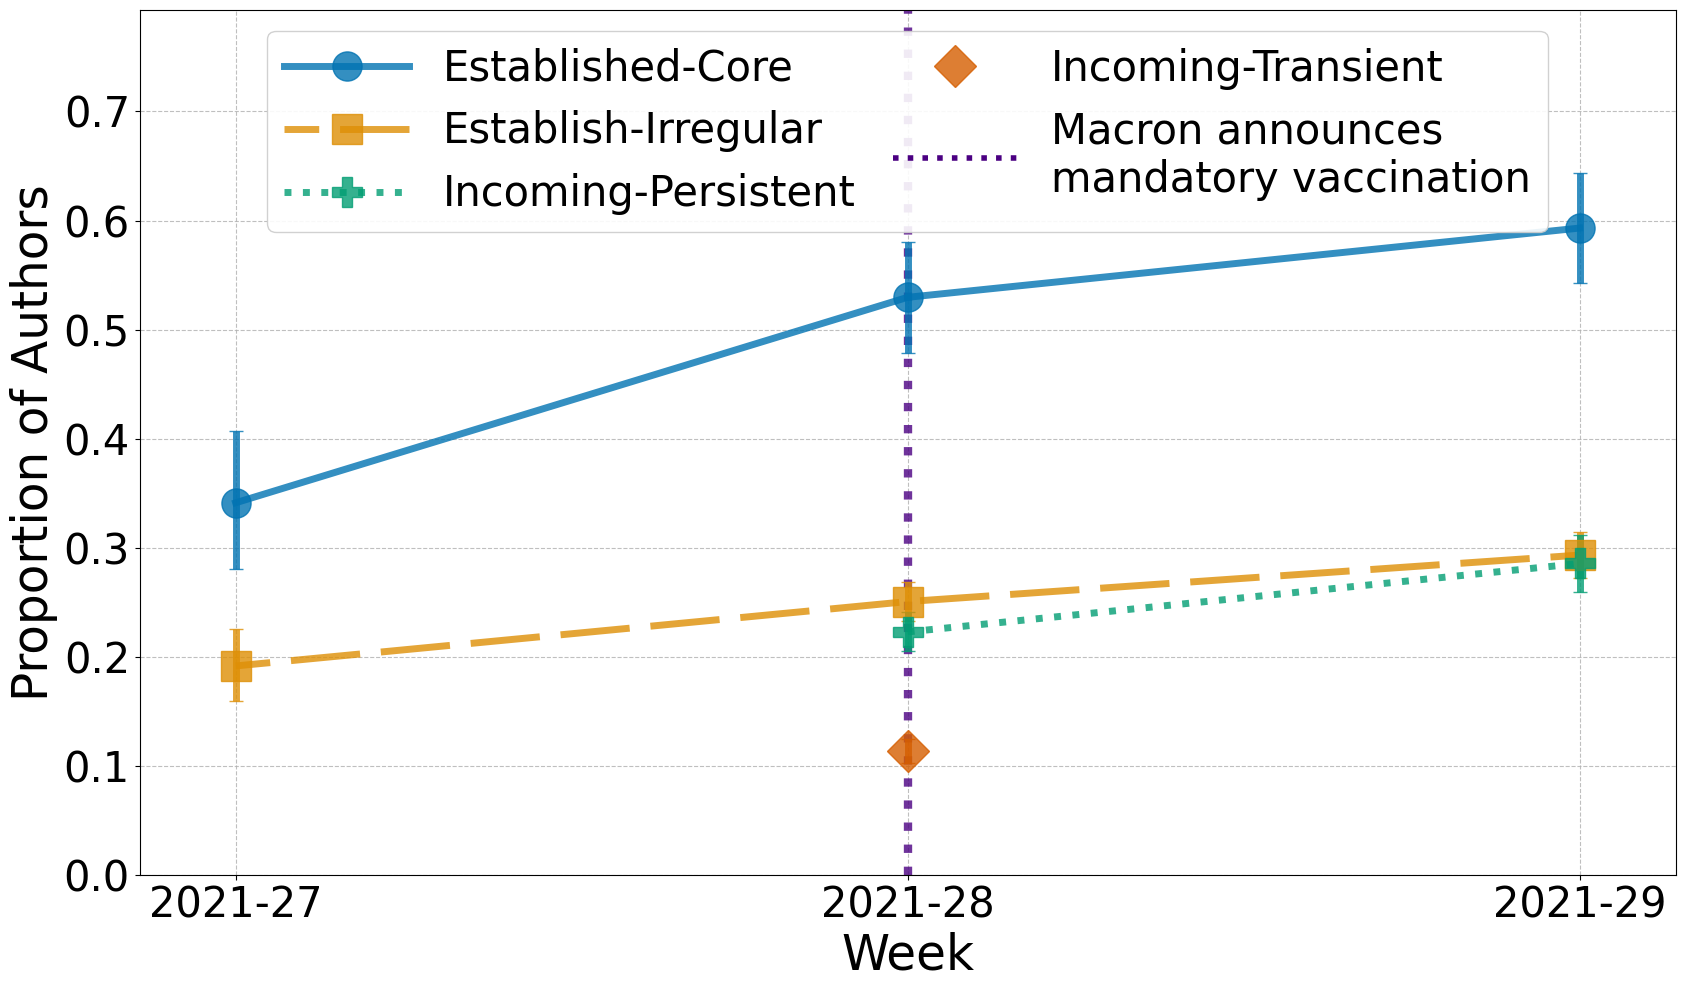

In [ ]:
# from gensim.models import Word2Vec
# import nltk
# from nltk.tokenize import word_tokenize
# import pandas as pd
# import re
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
from scipy.stats import binom
# import matplotlib.lines as mlines
# import matplotlib.patches as mpatches
# from collections import Counter
# nltk.download('punkt')

# Set a new color palette using seaborn
color_palette = sns.color_palette("colorblind")

# Define custom colors for different outgroup word categories
highlight_line_color = '#4B0082'
category_colors = color_palette#[:len(category_words)]

# Define markers for each category
markers = ['o', 's', 'P', 'D']#[:len(category_words)]  # Using different shapes for variety
linestyles = ['solid', (5, (10, 3)), 'dotted', '']#[:len(category_words)]

# Define the weeks of interest
weeks_of_interest = ['2021-27', '2021-28', '2021-29']

# Convert weeks of interest to datetime
weeks_of_interest_dates = [pd.to_datetime(f'{week}-1', format='%Y-%U-%w') for week in weeks_of_interest]

# Filter the DataFrame to include only these weeks
df_filtered_weeks = df[df['week'].isin(weeks_of_interest)]

# Dictionary of author groups
author_groups = {
    'Established-Core': activists_list,
    'Establish-Irregular': other_authors_list,
    'Incoming-Persistent': continued_authors_list,
    'Incoming-Transient': stopped_authors_list
}

# Initialize dictionary to store proportions and confidence intervals for each author group
group_proportions = {group_name: [] for group_name in author_groups.keys()}
group_conf_intervals = {group_name: [] for group_name in author_groups.keys()}

# Iterate over the weeks of interest
for week in weeks_of_interest:
    # Filter the DataFrame for the current week
    week_df = df_filtered_weeks[df_filtered_weeks['week'] == week]

    # Iterate through each author group
    for group_name, author_ids in author_groups.items():
        # Filter week data for this author group
        group_week_df = week_df[week_df['author_id'].isin(author_ids)]

        # Count unique authors using any word from the outgroup list
        authors_using_outgroup = set()
        for author_id, tokens in zip(group_week_df['author_id'], group_week_df['tokenized_text']):
            if any(word in tokens for word in outgroup_labels):
                authors_using_outgroup.add(author_id)

        # Calculate the proportion of authors in this group using outgroup words
        total_authors_in_group = len(group_week_df['author_id'].unique())
        count_using_outgroup = len(authors_using_outgroup)
        proportion_using_outgroup = count_using_outgroup / total_authors_in_group if total_authors_in_group > 0 else 0

        # Calculate 95% confidence intervals using the binomial proportion confidence interval
        if total_authors_in_group > 0:
            conf_interval = binom.interval(0.95, total_authors_in_group, proportion_using_outgroup, loc=0)
            conf_interval = [ci / total_authors_in_group for ci in conf_interval]  # Convert counts to proportions
        else:
            conf_interval = [0, 0]

        # Append proportion and confidence intervals to the corresponding group
        group_proportions[group_name].append(proportion_using_outgroup)
        group_conf_intervals[group_name].append(conf_interval)

# Create a DataFrame to store the proportions
group_proportions_df = pd.DataFrame({
    'Week': weeks_of_interest_dates,
    **group_proportions
})

# Create a new figure
fig, ax = plt.subplots(figsize=(17, 10))

# Define Macron's announcement date and the end date for shading
announcement_date = pd.to_datetime('2021-28-1', format='%Y-%U-%w')
end_date = announcement_date + pd.DateOffset(weeks=2)

# Add the dotted red line for Macron's announcement
#ax.axvline(x=announcement_date, color=highlight_line_color, linestyle='dotted', linewidth=2, label='Macron announces mandatory vaccination', zorder=1)

# Vertical line for Macron speech
ax.axvline(x=announcement_date, color=highlight_line_color, linestyle='dotted', linewidth=6, alpha=0.8)

# Extend the shaded area from the announcement date to 2 weeks after
#ax.axvspan(announcement_date, end_date, facecolor="grey", alpha=0.08, zorder=0)

# Plot the proportions with error bars (confidence intervals)
for i, group_name in enumerate(group_proportions.keys()):
    non_zero_weeks = [week for i, week in enumerate(group_proportions_df['Week']) if group_proportions_df[group_name][i] > 0]
    non_zero_proportions = [prop for prop in group_proportions_df[group_name] if prop > 0]
    non_zero_conf_intervals = [group_conf_intervals[group_name][i] for i, prop in enumerate(group_proportions_df[group_name]) if prop > 0]
    lower_bounds, upper_bounds = zip(*non_zero_conf_intervals)

    plt.errorbar(non_zero_weeks, non_zero_proportions, yerr=[np.subtract(non_zero_proportions, lower_bounds),
                                                             np.subtract(upper_bounds, non_zero_proportions)],
                 marker=markers[i], linestyle=linestyles[i], label=group_name, capsize=5, c=category_colors[i], linewidth=5, ms=21, alpha=0.8)

# Set axis labels
plt.xlabel('Week', fontsize=35)
plt.ylabel('Proportion of Authors', fontsize=35)

# Customize x-ticks and labels
plt.xticks(weeks_of_interest_dates, [week.strftime('%Y-%U') for week in weeks_of_interest_dates], fontsize=30)
plt.yticks(fontsize=30)

# Adjust axis limits
ax.set_xlim(weeks_of_interest_dates[0] - pd.DateOffset(weeks=0.2), weeks_of_interest_dates[-1] + pd.DateOffset(weeks=0.2))
ax.set_ylim(0, max(max(group_proportions_df[group_name]) for group_name in group_proportions.keys()) + 0.2)

# Create custom legend handles
handles = [
    mlines.Line2D([0], [0], color=category_colors[i], marker=markers[i], linestyle=linestyles[i],
                  markersize=21, linewidth=5, label=group_name, alpha=0.8)
    for i, group_name in enumerate(group_proportions.keys())
] + [
    mlines.Line2D([0], [0], color=highlight_line_color, linestyle='dotted', linewidth=4,
                  label='Macron announces\nmandatory vaccination')  # Added newline
]
#+ [
    #mlines.Line2D([0], [1], color=highlight_line_color, linestyle='dotted', linewidth=4,
    #              label='Macron announces mandatory vaccination'),
    #mpatches.Patch(facecolor='grey', alpha=0.25, label='Post-announcement period')  # Adding grey area to the legend
#]

# Place the legend below the plot with fewer columns and adjust spacing
ax.legend(handles=handles, fontsize=30, loc='upper center', ncol=2, framealpha=0.9, columnspacing=0.9, handlelength=3)

# Enable grid
ax.grid(True, linestyle='--', alpha=0.8)

# Final plot adjustments
plt.tight_layout()
plt.savefig(path_folder+"figures/outgroup_author_groups_evolution_nobot.png", dpi=200)
plt.show()

In [ ]:
# Build dictionary from df (dropping duplicates to ensure 1 score per author)
bot_dict = df.drop_duplicates("author_id").set_index("author_id")["bot_score"].to_dict()

In [ ]:
path_data = "data/"
# Load the sentence embeddings DataFrame
df = pd.read_pickle(path_data+"df_sentenceembeddings.pkl")

df["created_at"] = pd.to_datetime(df["created_at"], utc=True)

In [ ]:
df["bot_score"] = df["author_id"].map(bot_dict)

In [ ]:
print(f"Original tweets: {len(df)}")

# Remove rows where bot_score > 0.5
df = df[(df["bot_score"].isna()) | (df["bot_score"] <= 0.5)].copy()

print(f"Remaining tweets after removing likely bots: {len(df)}")
print(f"Removed {338641 - len(df)} tweets from accounts with bot_score > 0.5")

Original tweets: 338641
Remaining tweets after removing likely bots: 338641
Removed 0 tweets from accounts with bot_score > 0.5


In [ ]:
# Calculate the top 10% authors who publish the most
top_10_percent_authors = df['author_id'].value_counts().nlargest(int(len(df['author_id'].unique()) * 0.1)).index

# Filter the DataFrame based on the top 10% authors
df_top_10_percent = df[df['author_id'].isin(top_10_percent_authors)]

# Function to filter authors based on the new condition
def filter_activists(df):
    # Get the number of unique months each author has posted in
    author_post_months = df.groupby('author_id')['created_at'].apply(lambda x: x.dt.month.nunique())

    # Filter authors who have posted in every month
    prolific_authors = author_post_months[author_post_months >= 10].index

    # Filter the DataFrame based on prolific authors
    df_activists = df[df['author_id'].isin(prolific_authors)]

    return df_activists

# Apply the prolific condition to the original DataFrame
df_activists = filter_activists(df_top_10_percent)

# Define the start date (July 12th, 2021)
start_date = '2021-28'

# Get the first post date for each author in the entire dataset
first_post_dates = df.groupby('author_id')['week'].min()

# Identify authors who first posted on July 12th, 2021
first_post_july_12th = first_post_dates[first_post_dates == start_date].index

# Filter the dataset to include only authors who first posted on July 12th, 2021
authors_started_on_july_12th_df = df[df['author_id'].isin(first_post_july_12th)]

# Filter the dataset to include only authors who continued posting after July 12th, 2021
#authors_posted_after_july_12th = authors_posted_on_july_12th[authors_posted_on_july_12th['week'] > start_date]

# Filter the data to include only authors who posted after July 12th, 2021
#filtered_df_posted_after_july_12th = df[df['author_id'].isin(authors_posted_after_july_12th['author_id'])]

# Define the function to filter authors based on the new condition
def filter_authors_stopped(df, first_post_july_12th):
    # Get the last post date for each author in the entire dataset
    last_post_dates = df.groupby('author_id')['week'].max()

    # Identify authors who first posted on 2021-28 and never posted after
    last_post_july_12th = last_post_dates[last_post_dates == '2021-28'].index
    first_last_post_july_12th = list(set(last_post_july_12th).intersection(set(first_post_july_12th)))

    # Filter the dataset to include only authors who first posted on 2021-28 and never posted after
    authors_stopped_df = df[df['author_id'].isin(first_last_post_july_12th)]

    return authors_stopped_df

# Apply the new condition to the original DataFrame
authors_stopped_df = filter_authors_stopped(df, first_post_july_12th)

# Get the index of authors to be removed
authors_to_remove_index = authors_started_on_july_12th_df[authors_started_on_july_12th_df['author_id'].isin(authors_stopped_df['author_id'])].index

# Remove authors from authors_posted_on_july_12th
authors_continued_df = authors_started_on_july_12th_df.drop(authors_to_remove_index)

# Get the list of all author IDs in the DataFrame
all_authors = df['author_id'].unique()

# Get the list of authors who are prolific
activists_list = df_activists['author_id'].unique()

# Get the list of authors who started but did not continue
stopped_authors_list = authors_stopped_df['author_id'].unique()

# Get the list of authors who started and continue
continued_authors_list = authors_continued_df['author_id'].unique()

# # Create a list of authors not included in any of the other groups
# other_authors_list = [author for author in all_authors if author not in activists_list
#                       and author not in stopped_authors_list and author not in continued_authors_list]

# # Filter the DataFrame to include only authors in the "other" group
# df_other_authors = df[df['author_id'].isin(other_authors_list)]

# Step 1: Identify authors who started posting before 2021-28
authors_started_before_july_12th = first_post_dates[first_post_dates < '2021-28'].index

# Step 2: Ensure these authors are not part of the activists, stopped, or continued groups
# Create a set of authors who are not activists, stopped, or continued
excluded_authors = set(activists_list).union(stopped_authors_list).union(continued_authors_list)

# Filter out authors who are in the excluded groups
other_authors_list = [author for author in authors_started_before_july_12th if author not in excluded_authors]

# Step 3: Filter the DataFrame to include only authors in the "other" group
df_other_authors = df[df['author_id'].isin(other_authors_list)]

In [ ]:
print(len(activists_list), len(stopped_authors_list), len(continued_authors_list), len(other_authors_list))

427 3321 2068 8931


0.5109973 0.37979206
T-test between 'Established Core' and 'Established Irregular': Statistic=191.18157647936857, p-value=0.0


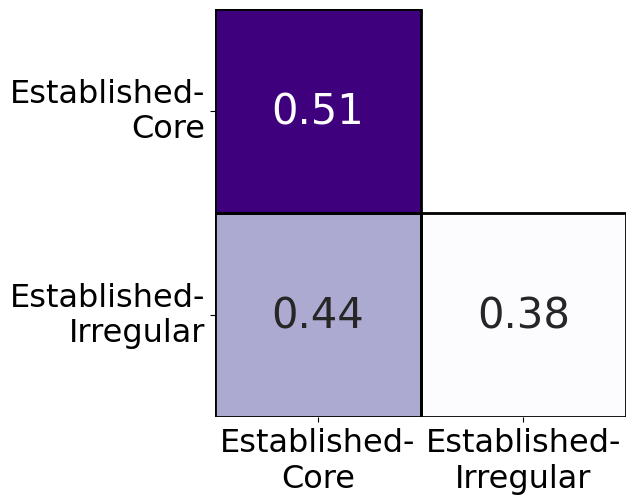

In [ ]:
# Function to calculate similarity between sentence embeddings of different groups
def calculate_similarity(sentence_embeddings_group1, sentence_embeddings_group2):
    similarity_matrix = cosine_similarity(sentence_embeddings_group1, sentence_embeddings_group2)

    num_samples = similarity_matrix.size - (similarity_matrix.shape[0] if np.array_equal(sentence_embeddings_group1, sentence_embeddings_group2) else 0)
    sum_similarity = similarity_matrix.sum() - (np.trace(similarity_matrix) if np.array_equal(sentence_embeddings_group1, sentence_embeddings_group2) else 0)

    average_similarity = sum_similarity / num_samples
    return average_similarity, similarity_matrix

# Function to get user centroids for a given week
def get_user_centroids(df, week):
    week_df = df[df['week'] == week]
    return week_df.groupby('author_id')['embeddings'].apply(
        lambda x: torch.stack([torch.tensor(item) for item in x]).mean(dim=0)).reset_index()

# Function to convert tensor centroids to numpy arrays
def convert_to_numpy(user_centroids):
    user_centroids_np = [centroid.numpy() for centroid in user_centroids["embeddings"].values if centroid.numel() > 1]
    return torch.tensor(user_centroids_np).numpy()

# Function to analyze similarities and perform t-tests
def analyze_groups(user_centroids_np, group_indices):
    means = np.zeros((len(group_indices), len(group_indices)))

    for i in range(len(group_indices)):
        for j in range(len(group_indices)):
            if i == j:
                means[i, j], _ = calculate_similarity(user_centroids_np[group_indices[i]], user_centroids_np[group_indices[i]])
            else:
                _, similarity_matrix = calculate_similarity(user_centroids_np[group_indices[i]], user_centroids_np[group_indices[j]])
                means[i, j] = similarity_matrix.mean()

    return means

# Function to generate heatmap
def plot_heatmap(heatmap_data, group_names, week):
    mask = np.triu(np.ones_like(heatmap_data, dtype=bool), k=1)
    staggered_group_names = [name.replace(" ", "-\n") for name in group_names]
    # Adjust the size of the figure based on the number of groups
    num_groups = len(group_names)

    # Ensure that the cells are square by adjusting the figure size
    plt.figure(figsize=(num_groups * 2.65, num_groups * 2.65))  # Scale size with the number of groups

    sns.heatmap(heatmap_data, annot=True, cmap='Purples', fmt=".2f",
                xticklabels=staggered_group_names, yticklabels=staggered_group_names,
                annot_kws={"size": 30}, mask=mask, cbar=False)

    for (i, j), val in np.ndenumerate(mask):
        if val:  # If the cell is masked
            continue
        else:
          plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=2))


    #plt.title(f'Week {week}', fontsize=40)
    plt.yticks(fontsize=23, rotation=0)
    plt.xticks(ha='center', fontsize=23, rotation_mode="anchor")

    #plt.tight_layout(pad=0)
    plt.savefig(path_folder+f'figures/heatmap_week_{week}_nobot.png', dpi=200, bbox_inches="tight")
    plt.show()

# Main function to run the analysis for a given week
def run_week_analysis(df, week, group_data):
    # Get user centroids for the given week
    user_centroids_week = get_user_centroids(df, week)

    # Convert centroids to numpy array
    user_centroids_np = convert_to_numpy(user_centroids_week)

    # Extract group indices
    group_indices = [user_centroids_week[user_centroids_week.author_id.isin(group)].index for group in group_data['groups']]

    # Perform similarity analysis
    heatmap_data = analyze_groups(user_centroids_np, group_indices)

    # Perform t-tests between all groups using the flattened similarity matrices
    t_test_results = []
    for i in range(len(group_indices)):
        for j in range(i + 1, len(group_indices)):
            sim_i = cosine_similarity(user_centroids_np[group_indices[i]])
            sim_j = cosine_similarity(user_centroids_np[group_indices[j]])
            print(sim_i.flatten().mean(), sim_j.flatten().mean())
            t_stat, p_val = ttest_ind(sim_i.flatten(), sim_j.flatten())
            t_test_results.append((group_data['names'][i], group_data['names'][j], t_stat, p_val))

    # Print t-test results
    for name1, name2, t_stat, p_val in t_test_results:
        print(f"T-test between '{name1}' and '{name2}': Statistic={t_stat}, p-value={p_val}")

    # Plot heatmap
    plot_heatmap(heatmap_data, group_data['names'], week)

# Example usage
group_data_week_27 = {
    'groups': [set(df_activists['author_id']), set(other_authors_list)],
    'names': ['Established Core', 'Established Irregular']
}

run_week_analysis(df, '2021-27', group_data_week_27)

0.59705675 0.43845484
0.59705675 0.40475518
0.59705675 0.31356838
0.43845484 0.40475518
0.43845484 0.31356838
0.40475518 0.31356838
T-test between 'Established Core' and 'Established Irregular': Statistic=339.07805633307225, p-value=0.0
T-test between 'Established Core' and 'Incoming Persistent': Statistic=432.80462717732047, p-value=0.0
T-test between 'Established Core' and 'Incoming Transient': Statistic=666.226717562347, p-value=0.0
T-test between 'Established Irregular' and 'Incoming Persistent': Statistic=302.0250497806963, p-value=0.0
T-test between 'Established Irregular' and 'Incoming Transient': Statistic=1430.8671905173992, p-value=0.0
T-test between 'Incoming Persistent' and 'Incoming Transient': Statistic=979.0804577776877, p-value=0.0


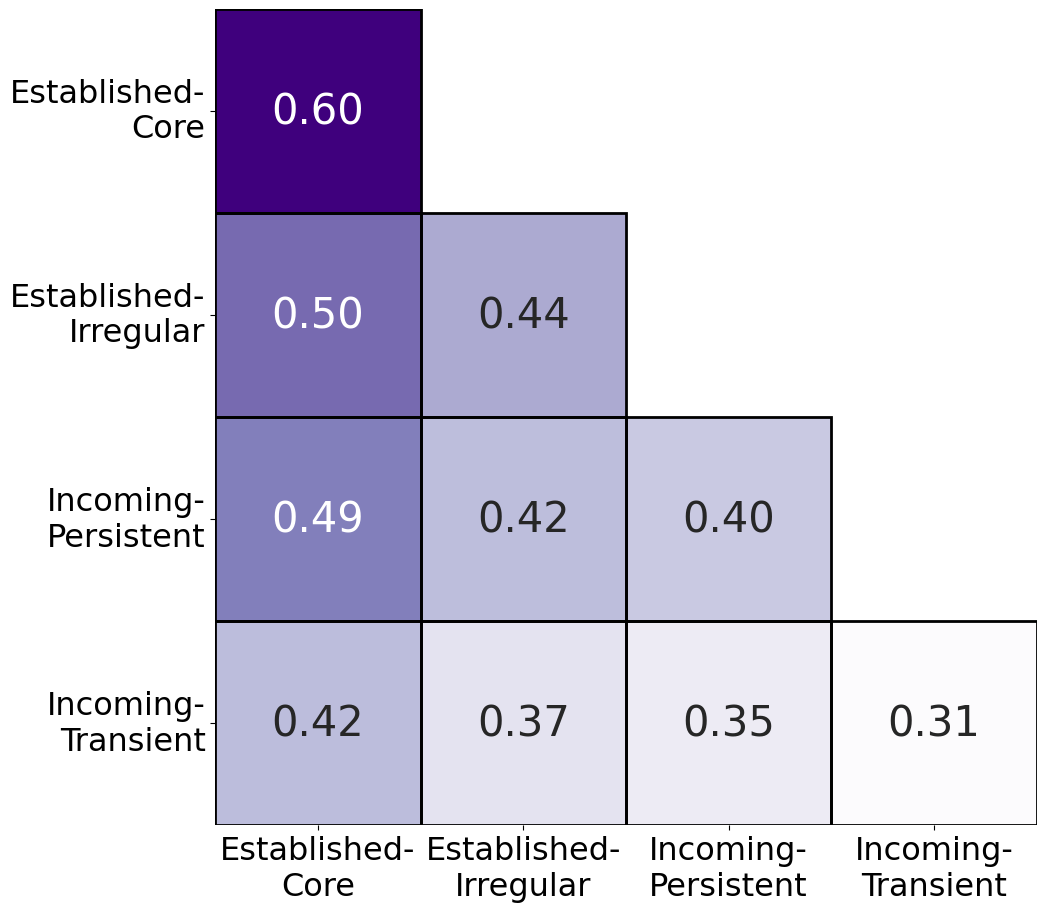

In [ ]:
# Example usage
group_data_week_28 = {
    'groups': [
        set(df_activists['author_id']),
        set(other_authors_list),
        set(authors_continued_df['author_id']),
        set(authors_stopped_df['author_id'])
    ],
    'names': ['Established Core', 'Established Irregular', 'Incoming Persistent', 'Incoming Transient']
}

run_week_analysis(df, '2021-28', group_data_week_28)

0.63707614 0.47357267
0.63707614 0.46405408
0.47357267 0.46405408
T-test between 'Established Core' and 'Established Irregular': Statistic=377.8606581505119, p-value=0.0
T-test between 'Established Core' and 'Incoming Persistent': Statistic=377.5359231759063, p-value=0.0
T-test between 'Established Irregular' and 'Incoming Persistent': Statistic=56.81664011603043, p-value=0.0


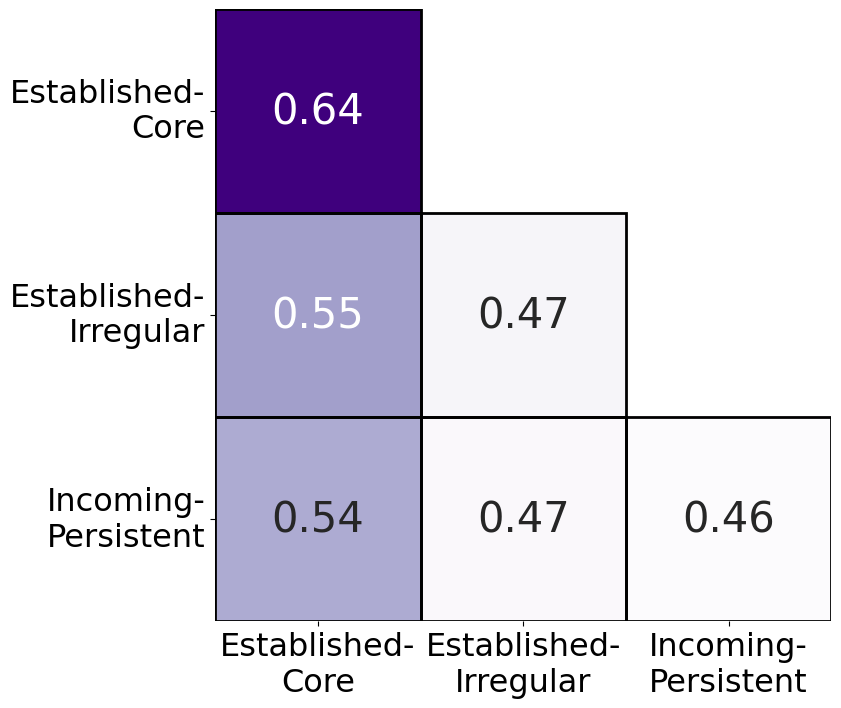

In [ ]:
# Example usage
group_data_week_29 = {
    'groups': [set(df_activists['author_id']), set(other_authors_list),
              set(authors_continued_df['author_id'])],
    'names': ['Established Core', 'Established Irregular', 'Incoming Persistent']
}

run_week_analysis(df, '2021-29', group_data_week_29)